# Model evaluation for regression + cross-validation 

Now that we have learned about cross-validation and model evaluation more generally, its time to see how we can perform cross validation in practice.  To make things as understandable we pull apart the basic cross-validation procedure and expose it in notebook, and use the sort of toy regression / classification datasets we have seen previously.  This is so we can more easily understand all of the operations taking place with cross validation.  However in the future when dealing with real data we will instead use scikit-learn's built in cross validation functionality.

In [1]:
### in this cell we import necessary libraries for the demo
import numpy as np                                        # a fundamental numerical linear algebra library
import matplotlib.pyplot as plt                           # a basic plotting library
import pandas as pd
import model_eval_regression_utils as utils               # utilities for this notebook

# this line is required in order to plot in a jupyter notebook itself
%matplotlib inline      

# Cross-validation for regression

In the next cell we create a familiar sinusoidal dataset.  Afterwards we walk through the three prototypical algorithms we looked at earlier in the regression notebook and tune their parameters automatically using cross-validation

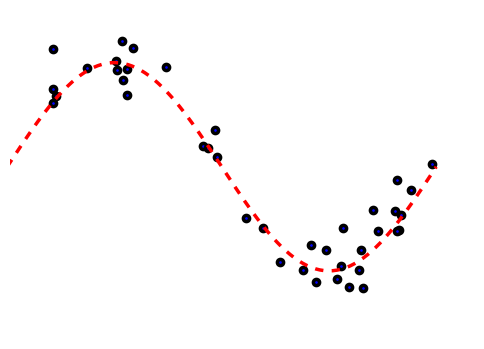

In [2]:
# generate the data - here sep_x and sep_y are the coordinates of the unit circle true separator between the two classes
data,true_func = utils.generate_regression_data(num_pts = 40)

From the regression notebook we know that - regardless of the nonlinear regression algorithm we choose - we will need tune at least one parameter.  In this notebook we will follow up with what we learned in lecture - and see how to do this automatically using cross-validation.

First we need to create a simple cross-validation function.  From lecture you saw how the basic cross-validation procedure entails


- splitting the dataset into training and testing sets (usually around 20% - 10% of the data is kept aside for the testing set)


- training a given model over a range of parameter values


- evaluating each model on the training and testing sets


- the best choice of parameter is the one providing minimum **testing error**


In the next Python cell we provide just such a function.  It takes in an arbitrary regressor, with custom parameter name and range for testing.  Study this function before using it in the cells that follow.

In [3]:
# classification cross-validation function
from sklearn.model_selection import train_test_split
def simple_cross_validation(data,clf,param_name,param_range):
    # here clf = a user-defined classification algorithm, param_name = a parameter of clf, and param_range = user-defined range of parameters of type param_name
    # split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data[:,0],data[:,1], test_size=0.3, random_state=42)

    # prep training and testing data for plotting
    train_data = np.asarray([x_train,y_train])
    train_data = train_data.T
    test_data = np.asarray([x_test,y_test])
    test_data = test_data.T
    utils.plot_train_test(train_data, test_data)
    
    # compute training and testing errors over range of parameters = param_range
    x_train = x_train[:, np.newaxis]
    x_test = x_test[:, np.newaxis]
    
    train_errors = list()
    test_errors = list()
    for param in param_range:
        # set chosen parameter to desired value
        exec 'clf.' + param_name + ' = ' +  str(param) in locals(),globals()  
        clf.fit(x_train, y_train)
        train_pred = clf.predict(x_train)
        test_pred = clf.predict(x_test)

        # compute training and testing accuracy 
        train_accuracy = np.linalg.norm(y_train - train_pred)**2/float(len(y_train))
        test_accuracy = np.linalg.norm(y_test - test_pred)**2/float(len(y_test))

        train_errors.append(train_accuracy)
        test_errors.append(test_accuracy)
        
    # return training and testing errors
    return train_errors, test_errors

One more function - optional but helpful for visualization purposes: a small plotting function that will plot both training and testing errors together.

In [4]:
# plot training and testing errors
def plot_cv_scores(train_errors,test_errors,param_range):
    # plot training and testing errors
    fig = plt.figure(figsize = (4,4))
    plt.plot(param_range,train_errors,marker = 'o',color =[1,0.8,0.5])
    plt.plot(param_range,test_errors,marker = 'o',color = [0,0.7,1])

    # clean up plot
    plt.xlabel('parameter values')
    plt.ylabel('error')
    plt.title('cross validation errors',fontsize = 14)
    plt.legend(['training error','testing error'],loc='center left', bbox_to_anchor=(1, 0.5))

## Cross-validation with the KernelRidge regressor
Its time to test our regression algorithms using cross validation.

First up - Kernel Ridge with a polynomial kernel.  Here the parameter we need to tune is the 'degree' - which takes on a non-negative integer value.  The param_range has been preset - but you can change it to whatever you prefer.  The same goes for the kernel type (Google 'scikit-learn Kernel Ridge' to see other types of kernels you can use).  Make sure to keep the parameter 'alpha' = 0 in these experiments.

/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


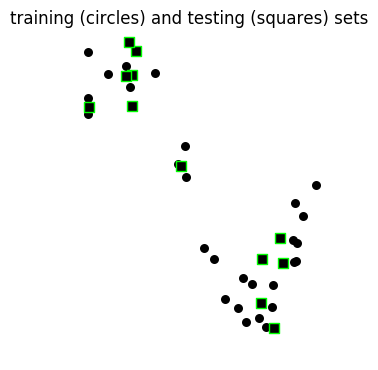

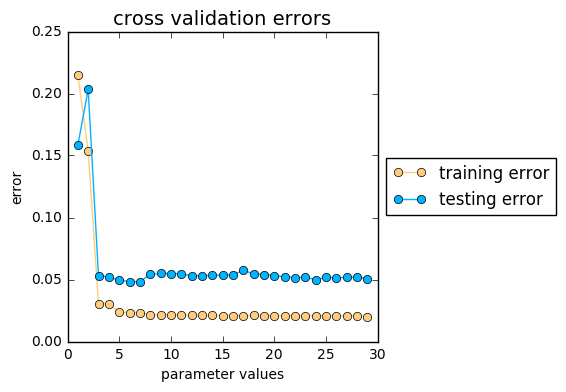

In [5]:
# KernelRidge is a kernel regressor function from the scikit-learn library
from sklearn.kernel_ridge import KernelRidge

# create an instance with a polynomial kernel
clf = KernelRidge(kernel = 'poly',alpha = 0)
param_name = 'degree'
param_range = np.arange(1,30)

# run our custom cross-validation function for this choice of classifier and param_name
train_errors, test_errors  = simple_cross_validation(data,clf,param_name,param_range)

# plot training and testing errors - as well as training and testing datasets
plot_cv_scores(train_errors,test_errors,param_range)

Now that we have computed the training and testing errors, lets choose the best one and then fit the corresponding regression model to our dataset.

our best cross-validated choice of parameter was: degree = 7


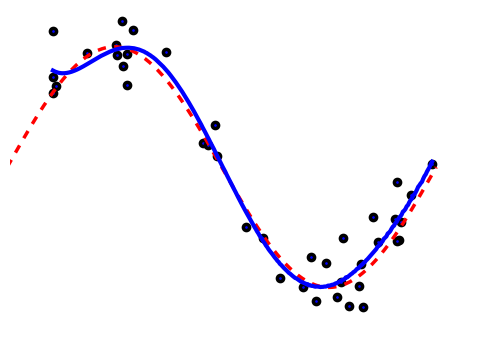

In [6]:
# pick the best parameter - i.e., the one that minimizes test error
best_param = param_range[np.argmin(test_errors)]
print 'our best cross-validated choice of parameter was: ' + param_name + ' = ' + str(best_param)

# create an instance of a kernel-based regressor from scikit learn
clf = KernelRidge(kernel = 'poly',degree = best_param,alpha = 0)

# fit our chosen regressor to the dataset
data_x = data[:,0]
data_y = data[:,1]
clf.fit(data_x[:, np.newaxis], data_y)  

# plot pts and approximation
utils.plot_data(data,true_func)
utils.plot_approx(clf,data)

## Cross-validation with the neural network regressor

Up next - a neural network.  Here the parameter we need to tune is called 'hidden_layer_sizes' - which takes on a non-negative integer value.  The param_range has been preset - but you can change it to whatever you prefer.  The same goes for the parameter type and activation function type (Google 'scikit-learn neural network regression' to see other types of parameters you can use).  Just don't change the 'solver' - because other solvers tend not to work well on small datasets like ours.

Typically in practice a neural network has a number of parameters that need tuning, and functions / architecture that need to be chosen.  But for our simple experiment a single paramter will do just fine.

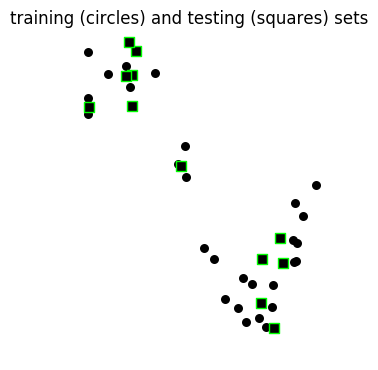

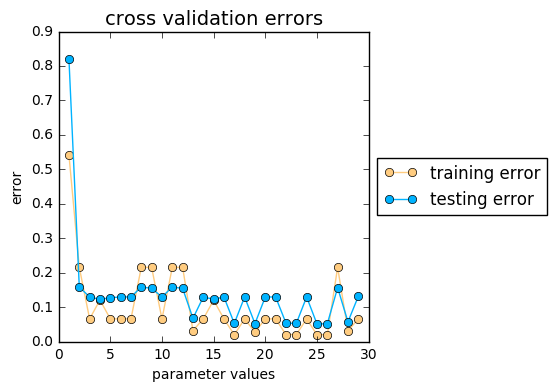

In [7]:
# import the neural network regressor from scikit
from sklearn.neural_network import MLPRegressor           

# create an instance 
clf = MLPRegressor(solver = 'lbgfs')
param_name = 'hidden_layer_sizes'
param_range = np.arange(1,30)

# run our custom cross-validation function for this choice of classifier and param_name
train_errors, test_errors  = simple_cross_validation(data,clf,param_name,param_range)

# plot training and testing errors
plot_cv_scores(train_errors,test_errors,param_range)

Now lets fit a neural network model to the dataset with minimial testing error.

our best cross-validated choice of parameter was: hidden_layer_sizes = 25


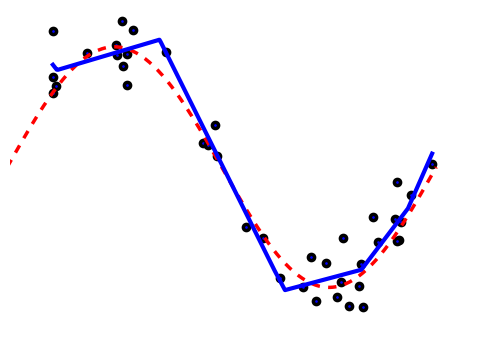

In [8]:
# pick the best parameter - i.e., the one that minimizes test error
best_param = param_range[np.argmin(test_errors)]
print 'our best cross-validated choice of parameter was: ' + param_name + ' = ' + str(best_param)

# create an instance of a kernel-based regressor from scikit learn
clf = MLPRegressor(solver = 'lbgfs',hidden_layer_sizes = best_param)

# fit our chosen regressor to the dataset
data_x = data[:,0]
data_y = data[:,1]
clf.fit(data_x[:, np.newaxis], data_y)  

# plot pts and approximation
utils.plot_data(data,true_func)
utils.plot_approx(clf,data)

Last - but certainly not least - lets perform this exercise using a tree-based algorithm (here we use the excellent gradient boosting scheme).  Here the parameter we will be tuning is called 'n_estimators'.  Google 'scikit-learn + gradient boosting' to see other parameters can be tuned as well.  Keep the 'max_depth' parameter set to 5 for this experiment.

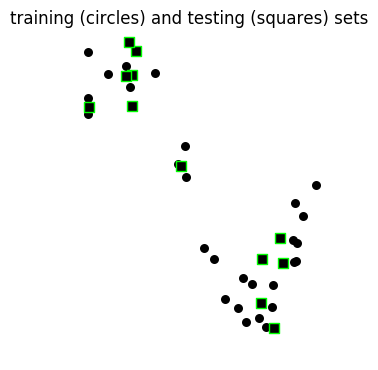

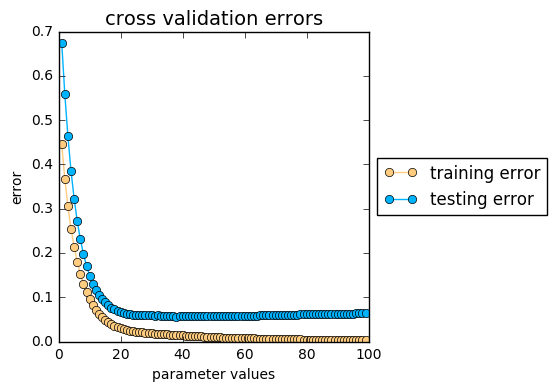

In [9]:
# import the gradient boosting regressor from scikit
from sklearn.ensemble import GradientBoostingRegressor   

# load in gradient booster
clf = GradientBoostingRegressor(max_depth = 2)
param_name = 'n_estimators'
param_range = np.arange(1,100)

# run our custom cross-validation function for this choice of classifier and param_name
train_errors, test_errors  = simple_cross_validation(data,clf,param_name,param_range)

# plot training and testing errors
plot_cv_scores(train_errors,test_errors,param_range)

Now lets fit a gradient boosting model to the dataset with minimial testing error.

our best cross-validated choice of parameter was: n_estimators = 38


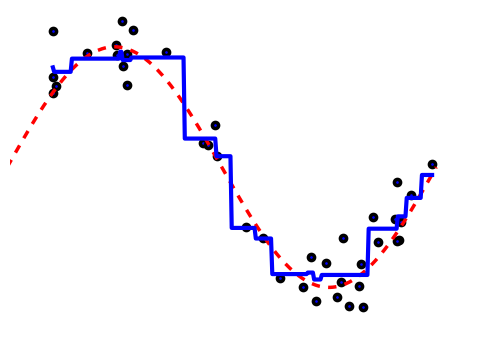

In [10]:
# pick the best parameter - i.e., the one that minimizes test error
best_param = param_range[np.argmin(test_errors)]
print 'our best cross-validated choice of parameter was: ' + param_name + ' = ' + str(best_param)

# create an instance of a kernel-based regressor from scikit learn
clf = GradientBoostingRegressor(n_estimators = best_param, max_depth = 2)

# fit our chosen regressor to the dataset
data_x = data[:,0]
data_y = data[:,1]
clf.fit(data_x[:, np.newaxis], data_y)  

# plot pts and approximation
utils.plot_data(data,true_func)
utils.plot_approx(clf,data)

## Conclusions

What conclusions can you draw from these demonstrations?  Here are some ideas to get you started.


0)   Given the computational load of a single regression algorithm, what is (roughly) the computation required to perform the sort of cross-validation we used here for a single parameter with X choices of that parameter?  What if we have 10 parameters?



1)  Did you get the same results when you ran cross-validation twice for the same algorithm?  If they were different, how varied were your results?  Why were they different?


2)   Given the way we have split the dataset into training and testing sets, is it possible that our cross-validation can 'get it wrong' in terms of the best selection of a parameter?  How might this happen?  If it could occur - what might we do to ameliorate the problem you see?  Hint: drawing pictures here could help!


3)  Suppose we want to compare several algorithms (like the ones used here) - each of which we will tune via cross-validation.  In order to produce a fair comparison of the algorithms, what aspects of the cross-validation procedure should we keep fixed across each run of cross-validation?


4) What sort of behavior do you notice with cross-validation as you increase the size of the dataset?  Try performing a few experiments by making a larger dataset!


5)  What sort of behavior do you notice when you change the percentage of data left in the testing set?  Try performing a few experiments!